In [ ]:
#for calibration
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [ ]:
# 1. Define the Heston model characteristic function
def heston_charfunc(phi, S0, K, v0, kappa, theta, sigma, rho, tau, r, q=0):
    a = kappa * theta
    u = 0.5
    b = kappa
    d = np.sqrt((rho * sigma * phi * 1j - b) ** 2 - sigma ** 2 * (2 * u * phi * 1j - phi ** 2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    exp1 = 1j * phi * (np.log(S0) + (r - q) * tau)
    exp2 = (a / sigma ** 2) * ((b - rho * sigma * phi * 1j + d) * tau - 2 * np.log((1 - g * np.exp(d * tau)) / (1 - g)))
    cf = np.exp(exp1 + exp2 + v0 * (b - rho * sigma * phi * 1j + d) * (1 - np.exp(d * tau)) / (sigma ** 2 * (1 - g * np.exp(d * tau))))
    return cf

# 2. Define the Heston model price function
def heston_price(S0, K, v0, kappa, theta, sigma, rho, tau, r, q=0, option_type='call'):
    def integrand(phi):
        cf = heston_charfunc(phi - 1j, S0, K, v0, kappa, theta, sigma, rho, tau, r, q)
        numerator = np.exp(-1j * phi * np.log(K)) * cf
        return np.real(numerator / (1j * phi))

    integral = quad(integrand, 0, 100, limit=100)[0]
    P = 0.5 * (S0 * np.exp(-q * tau) - K * np.exp(-r * tau)) + (1 / np.pi) * integral
    if option_type == 'call':
        return P
    else:
        # Put-call parity
        return P - S0 * np.exp(-q * tau) + K * np.exp(-r * tau)

# 3. Define the calibration objective function
def calibration_objective(params, S0, market_data):
    v0, kappa, theta, sigma, rho = params
    error = 0.0
    for index, row in market_data.iterrows():
        K = row['strike']
        tau = row['maturity']
        r = row['rate']
        market_price = row['price']
        model_price = heston_price(S0, K, v0, kappa, theta, sigma, rho, tau, r)
        error += (market_price - model_price) ** 2
    return error

# 4. Prepare market data for Lonza Group AG
# Replace the placeholders with your actual data
# Example placeholder data for Lonza
data_lonza = {
    'strike': np.array([500, 525, 550, 575, 600]),  # Example strikes
    'maturity': np.array([0.25, 0.5, 0.75, 1.0, 1.25]),  # Maturities in years
    'rate': np.array([0.01, 0.012, 0.013, 0.015, 0.017]),  # Risk-free rates
    'price': np.array([60, 50, 40, 30, 20])  # Market option prices
}

market_data_lonza = pd.DataFrame(data_lonza)

S0_LONN = 549.60  # Current price of Lonza Group AG

# 5. Prepare market data for Sika AG
# Replace the placeholders with your actual data
# Example placeholder data for Sika
data_sika = {
    'strike': np.array([220, 230, 240, 250, 260]),  # Example strikes
    'maturity': np.array([0.25, 0.5, 0.75, 1.0, 1.25]),  # Maturities in years
    'rate': np.array([0.01, 0.012, 0.013, 0.015, 0.017]),  # Risk-free rates
    'price': np.array([40, 35, 30, 25, 20])  # Market option prices
}

market_data_sika = pd.DataFrame(data_sika)

S0_SIKA = 240.40  # Current price of Sika AG

# 6. Set initial guesses and bounds
# Initial guesses for parameters: [v0, kappa, theta, sigma, rho]
initial_params = [0.04, 2.0, 0.04, 0.3, -0.7]

# Bounds for parameters
bounds = [
    (1e-6, 2.0),    # v0
    (1e-3, 10.0),   # kappa
    (1e-6, 2.0),    # theta
    (1e-3, 2.0),    # sigma
    (-0.999, 0.999) # rho
]

# 7. Perform calibration for Lonza Group AG
result_lonza = minimize(
    calibration_objective,
    initial_params,
    args=(S0_LONN, market_data_lonza),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract calibrated parameters for Lonza
v0_LONN, kappa_LONN, theta_LONN, sigma_LONN, rho_LONN = result_lonza.x

# 8. Perform calibration for Sika AG
result_sika = minimize(
    calibration_objective,
    initial_params,
    args=(S0_SIKA, market_data_sika),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract calibrated parameters for Sika
v0_SIKA, kappa_SIKA, theta_SIKA, sigma_SIKA, rho_SIKA = result_sika.x

# 9. Evaluate calibration results
print("Calibration Results for Lonza Group AG:")
print(f"v0: {v0_LONN}, kappa: {kappa_LONN}, theta: {theta_LONN}, sigma: {sigma_LONN}, rho: {rho_LONN}")
print(f"Optimization Success: {result_lonza.success}, Message: {result_lonza.message}\n")

print("Calibration Results for Sika AG:")
print(f"v0: {v0_SIKA}, kappa: {kappa_SIKA}, theta: {theta_SIKA}, sigma: {sigma_SIKA}, rho: {rho_SIKA}")
print(f"Optimization Success: {result_sika.success}, Message: {result_sika.message}\n")

# 10. Plot calibration results
def plot_calibration_results(S0, market_data, v0, kappa, theta, sigma, rho, asset_name):
    model_prices = []
    for index, row in market_data.iterrows():
        K = row['strike']
        tau = row['maturity']
        r = row['rate']
        model_price = heston_price(S0, K, v0, kappa, theta, sigma, rho, tau, r)
        model_prices.append(model_price)

    plt.figure(figsize=(10, 6))
    plt.scatter(market_data['strike'], market_data['price'], label='Market Prices', color='blue')
    plt.scatter(market_data['strike'], model_prices, label='Model Prices', color='red', marker='x')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title(f'Calibration Results for {asset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Lonza Group AG
plot_calibration_results(S0_LONN, market_data_lonza, v0_LONN, kappa_LONN, theta_LONN, sigma_LONN, rho_LONN, 'Lonza Group AG')

# Plot for Sika AG
plot_calibration_results(S0_SIKA, market_data_sika, v0_SIKA, kappa_SIKA, theta_SIKA, sigma_SIKA, rho_SIKA, 'Sika AG')

# 11. Estimate correlation between the asset prices
# Replace the placeholders with your actual historical price data

# Example placeholder data for historical prices
# Date format: 'YYYY-MM-DD'
dates = pd.date_range(start='2023-01-01', periods=100, freq='B')  # Business days

prices_lonza = pd.DataFrame({
    'Date': dates,
    'Close_LONN': np.random.normal(loc=550, scale=10, size=100)  # Simulated prices
})

prices_sika = pd.DataFrame({
    'Date': dates,
    'Close_SIKA': np.random.normal(loc=240, scale=5, size=100)  # Simulated prices
})

# Merge data on dates
prices = pd.merge(prices_lonza, prices_sika, on='Date')

# Calculate daily returns
prices['Return_LONN'] = prices['Close_LONN'].pct_change()
prices['Return_SIKA'] = prices['Close_SIKA'].pct_change()

# Drop NaN values from returns
prices = prices.dropna()

# Calculate correlation
rho_asset_prices = prices[['Return_LONN', 'Return_SIKA']].corr().iloc[0, 1]
print(f"Correlation between Lonza and Sika asset prices: {rho_asset_prices}\n")

# 12. Update the parameters dictionary
params = {
    'v0_LONN': v0_LONN,
    'kappa_LONN': kappa_LONN,
    'theta_LONN': theta_LONN,
    'sigma_v_LONN': sigma_LONN,
    'rho_S_LONN_v_LONN': rho_LONN,
    'v0_SIKA': v0_SIKA,
    'kappa_SIKA': kappa_SIKA,
    'theta_SIKA': theta_SIKA,
    'sigma_v_SIKA': sigma_SIKA,
    'rho_S_SIKA_v_SIKA': rho_SIKA,
    'rho_S_LONN_S_SIKA': rho_asset_prices,
    # Assume rho_v_LONN_v_SIKA is estimated or set to a reasonable value
    'rho_v_LONN_v_SIKA': 0.2  # Placeholder value
}

# 13. Simulate the joint asset paths using the calibrated parameters
# Include your simulate_two_asset_heston function from earlier

def is_positive_definite(matrix):
    """Check if the matrix is positive definite."""
    return np.all(np.linalg.eigvals(matrix) > 0)

def simulate_two_asset_heston(S0_LONN, S0_SIKA, v0_LONN, v0_SIKA, params, T, N, M):
    dt = T / N
    mu = np.zeros(4)

    # Construct the covariance matrix
    cov_matrix = np.array([
        [1, params['rho_S_LONN_S_SIKA'], params['rho_S_LONN_v_LONN'], 0],
        [params['rho_S_LONN_S_SIKA'], 1, 0, params['rho_S_SIKA_v_SIKA']],
        [params['rho_S_LONN_v_LONN'], 0, 1, params['rho_v_LONN_v_SIKA']],
        [0, params['rho_S_SIKA_v_SIKA'], params['rho_v_LONN_v_SIKA'], 1]
    ])

    # Check if the covariance matrix is positive definite
    if not is_positive_definite(cov_matrix):
        raise ValueError("Covariance matrix is not positive definite. Please adjust the correlation coefficients.")

    # Cholesky decomposition
    L = np.linalg.cholesky(cov_matrix)

    # Initialize arrays
    S_LONN = np.full((N+1, M), S0_LONN)
    v_LONN = np.full((N+1, M), v0_LONN)
    S_SIKA = np.full((N+1, M), S0_SIKA)
    v_SIKA = np.full((N+1, M), v0_SIKA)

    for i in range(1, N+1):
        # Generate correlated Brownian increments
        Z = np.random.normal(size=(M, 4))
        dW = Z @ L.T * np.sqrt(dt)

        # Lonza Group AG
        v_LONN_prev = v_LONN[i-1]
        v_LONN_sqrt = np.sqrt(np.maximum(v_LONN_prev, 0))
        v_LONN[i] = v_LONN_prev + params['kappa_LONN'] * (params['theta_LONN'] - v_LONN_prev) * dt + params['sigma_v_LONN'] * v_LONN_sqrt * dW[:, 2]
        v_LONN[i] = np.maximum(v_LONN[i], 0)
        S_LONN[i] = S_LONN[i-1] * np.exp((r - 0.5 * v_LONN_prev) * dt + v_LONN_sqrt * dW[:, 0])

        # Sika AG
        v_SIKA_prev = v_SIKA[i-1]
        v_SIKA_sqrt = np.sqrt(np.maximum(v_SIKA_prev, 0))
        v_SIKA[i] = v_SIKA_prev + params['kappa_SIKA'] * (params['theta_SIKA'] - v_SIKA_prev) * dt + params['sigma_v_SIKA'] * v_SIKA_sqrt * dW[:, 3]
        v_SIKA[i] = np.maximum(v_SIKA[i], 0)
        S_SIKA[i] = S_SIKA[i-1] * np.exp((r - 0.5 * v_SIKA_prev) * dt + v_SIKA_sqrt * dW[:, 1])

    return S_LONN, v_LONN, S_SIKA, v_SIKA

# Simulation parameters
T = 1.25               # Time to maturity in years
r = 0.01               # Risk-free rate
N = 250                # Number of time steps in simulation
M = 10000              # Number of simulation paths

# Simulate the two assets
print("Starting asset path simulation...")
S_LONN, v_LONN, S_SIKA, v_SIKA = simulate_two_asset_heston(S0_LONN, S0_SIKA, v0_LONN, v0_SIKA, params, T, N, M)
print("Asset path simulation completed.")

# 14. Continue with your existing code to compute payoffs, simulate product price paths, etc.

# Note: Replace the placeholder code with your actual implementation from previous steps.


In [ ]:
#constants
import pandas as pd

initial_fixing_date:pd.Timestamp = pd.Timestamp('2023-04-27').tz_localize(None)

final_fixing_date:pd.Timestamp = pd.Timestamp('2024-07-30').tz_localize(None)

data_enddate : pd.Timestamp = pd.Timestamp('2024-07-30').tz_localize(None)

data_startdate : pd.Timestamp = pd.Timestamp('2010-01-01').tz_localize(None)

sim_start_date : pd.Timestamp = initial_fixing_date + pd.offsets.BDay(1)

ticker_list: list = ['LONN.SW', 'SIKA.SW']

sim_ticker : list = ['LONN.SW_sim', 'SIKA.SW_sim']

num_ticker :int = len(ticker_list)

n_steps_per_year = 252

dt = 1/n_steps_per_year

total_length_simulation = (final_fixing_date - initial_fixing_date).days + 1

interest_rate = 0.018

n_sims = 100

initialS1 : float = 549.60

initialS2 : float = 240.40

barrierS1 : float = 329.76

barrierS2 : float = 144.24

Starting asset path simulation...
Asset path simulation completed.
Starting product price computation...
Product price computation completed.
The expected price of the product is: 939.43


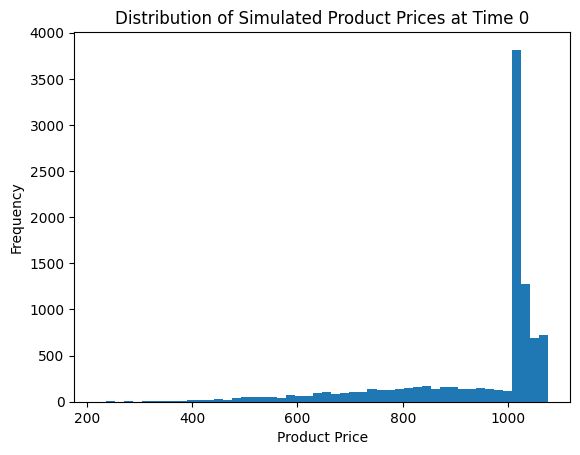

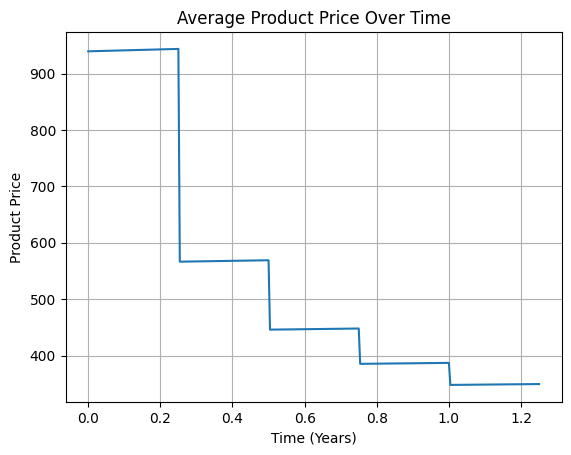

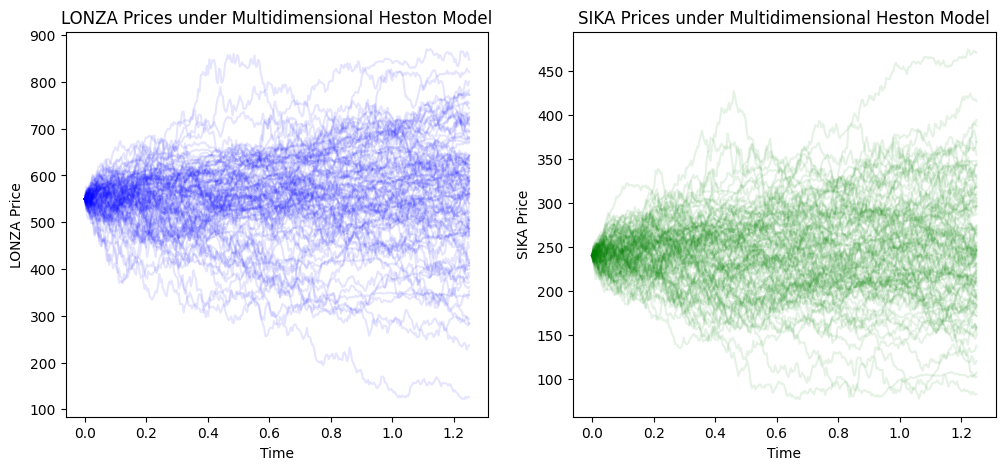

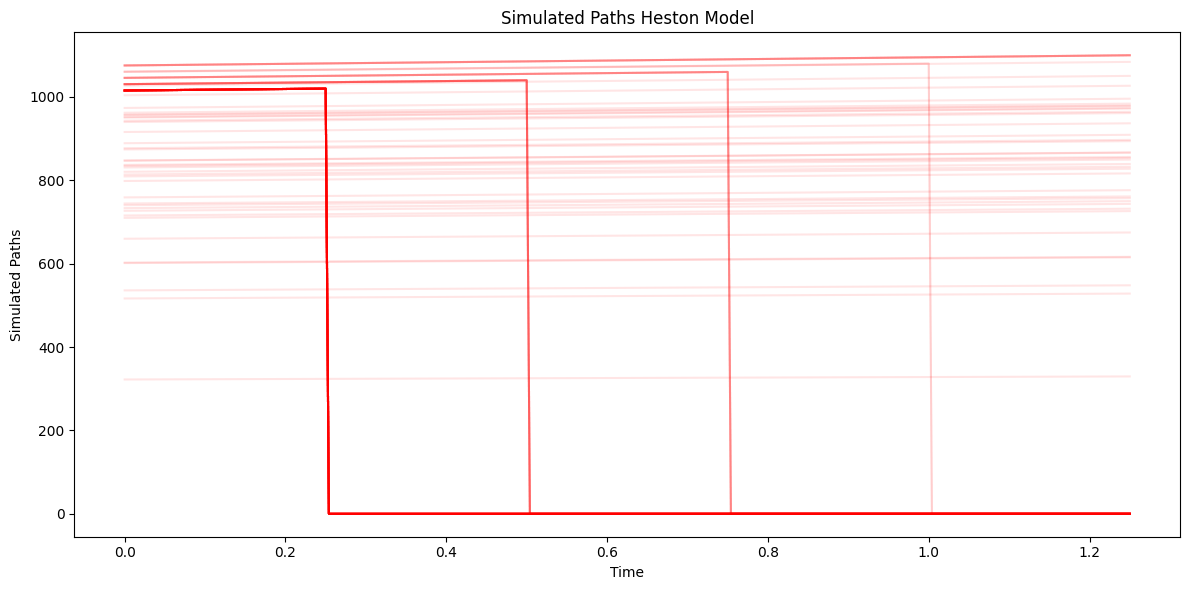

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
S0_LONN = 549.60       # Initial price of Lonza Group AG
S0_SIKA = 240.40       # Initial price of Sika AG
T = 1.25               # Time to maturity in years
r = 0.018               # Risk-free rate
N = 315                # Number of time steps in simulation
M = 10000              # Number of simulation paths

# Calibrated Heston parameters for Lonza Group AG
kappa_LONN = 3.0
theta_LONN = 0.20**2
v0_LONN = 0.25**2
rho_S_LONN_v_LONN = -0.7
sigma_v_LONN = 0.6

# Calibrated Heston parameters for Sika AG
kappa_SIKA = 2.5
theta_SIKA = 0.25**2
v0_SIKA = 0.30**2
rho_S_SIKA_v_SIKA = -0.6
sigma_v_SIKA = 0.5

# Correlations between assets
rho_S_LONN_S_SIKA = 0.5      # Correlation between asset prices
rho_v_LONN_v_SIKA = 0.3      # Correlation between variances

def simulate_two_asset_heston(S0_LONN, S0_SIKA, v0_LONN, v0_SIKA, params, T, N, M):
    dt = T / N
    mu = np.zeros(4)

        # Construct the covariance matrix
    cov_matrix = np.array([
        [1, params['rho_S_LONN_S_SIKA'], params['rho_S_LONN_v_LONN'], 0],
        [params['rho_S_LONN_S_SIKA'], 1, 0, params['rho_S_SIKA_v_SIKA']],
        [params['rho_S_LONN_v_LONN'], 0, 1, params['rho_v_LONN_v_SIKA']],
        [0, params['rho_S_SIKA_v_SIKA'], params['rho_v_LONN_v_SIKA'], 1]
    ])

    # Check if the matrix is positive definite
    try:
        L = np.linalg.cholesky(cov_matrix)
    except np.linalg.LinAlgError:
        # If not, make it positive definite by adding a small diagonal perturbation
        print("Warning: Covariance matrix is not positive definite. Applying a small perturbation.")
        min_eig = np.min(np.linalg.eigvals(cov_matrix))
        perturbation = np.abs(min_eig) + 1e-6  # Add a small value to the minimum eigenvalue
        cov_matrix += perturbation * np.eye(cov_matrix.shape[0])
        L = np.linalg.cholesky(cov_matrix)  # Retry Cholesky decomposition

    # Initialize arrays
    S_LONN = np.full((N+1, M), S0_LONN)
    v_LONN = np.full((N+1, M), v0_LONN)
    S_SIKA = np.full((N+1, M), S0_SIKA)
    v_SIKA = np.full((N+1, M), v0_SIKA)

    for i in range(1, N+1):
        # Generate correlated Brownian increments
        Z = np.random.normal(size=(M, 4))
        dW = Z @ L.T * np.sqrt(dt)

        # Lonza Group AG
        v_LONN_prev = v_LONN[i-1]
        v_LONN_sqrt = np.sqrt(np.maximum(v_LONN_prev, 0))
        v_LONN[i] = v_LONN_prev + params['kappa_LONN'] * (params['theta_LONN'] - v_LONN_prev) * dt + params['sigma_v_LONN'] * v_LONN_sqrt * dW[:, 2]
        v_LONN[i] = np.maximum(v_LONN[i], 0)
        S_LONN[i] = S_LONN[i-1] * np.exp((r - 0.5 * v_LONN_prev) * dt + v_LONN_sqrt * dW[:, 0])

        # Sika AG
        v_SIKA_prev = v_SIKA[i-1]
        v_SIKA_sqrt = np.sqrt(np.maximum(v_SIKA_prev, 0))
        v_SIKA[i] = v_SIKA_prev + params['kappa_SIKA'] * (params['theta_SIKA'] - v_SIKA_prev) * dt + params['sigma_v_SIKA'] * v_SIKA_sqrt * dW[:, 3]
        v_SIKA[i] = np.maximum(v_SIKA[i], 0)
        S_SIKA[i] = S_SIKA[i-1] * np.exp((r - 0.5 * v_SIKA_prev) * dt + v_SIKA_sqrt * dW[:, 1])

    return S_LONN, v_LONN, S_SIKA, v_SIKA

# Parameters dictionary
params = {
    'kappa_LONN': kappa_LONN,
    'theta_LONN': theta_LONN,
    'sigma_v_LONN': sigma_v_LONN,
    'rho_S_LONN_v_LONN': rho_S_LONN_v_LONN,
    'kappa_SIKA': kappa_SIKA,
    'theta_SIKA': theta_SIKA,
    'sigma_v_SIKA': sigma_v_SIKA,
    'rho_S_SIKA_v_SIKA': rho_S_SIKA_v_SIKA,
    'rho_S_LONN_S_SIKA': rho_S_LONN_S_SIKA,
    'rho_v_LONN_v_SIKA': rho_v_LONN_v_SIKA
}

# Simulate the two assets
print("Starting asset path simulation...")
S_LONN, v_LONN, S_SIKA, v_SIKA = simulate_two_asset_heston(S0_LONN, S0_SIKA, v0_LONN, v0_SIKA, params, T, N, M)
print("Asset path simulation completed.")

# Product parameters
params_product = {
    'Denomination': 1000,
    'Coupon_Rate': 0.08 / 4,  # Quarterly coupon payments
    'Barrier_LONN': 0.6 * S0_LONN,  # 60% barrier for Lonza
    'Barrier_SIKA': 0.6 * S0_SIKA,  # 60% barrier for Sika
    'Early_Redemption_Level_LONN': S0_LONN,
    'Early_Redemption_Level_SIKA': S0_SIKA,
    'S0_LONN': S0_LONN,
    'S0_SIKA': S0_SIKA,
    'T': T,
    'early_observation_times': [0.25, 0.5, 0.75, 1.0, 1.25],
}

def compute_payoff_paths(S_LONN_paths, S_SIKA_paths, params):
    M = S_LONN_paths.shape[1]
    N = S_LONN_paths.shape[0] - 1
    dt = params['T'] / N
    time_grid = np.linspace(0, params['T'], N+1)
    early_indices = [np.searchsorted(time_grid, t) for t in params['early_observation_times']]
    cash_flows = np.zeros((N+1, M))  # Cash flows at each time step

    for i in range(M):
        early_redeemed = False
        S_LONN = S_LONN_paths[:, i]
        S_SIKA = S_SIKA_paths[:, i]

        for idx, t_idx in enumerate(early_indices):
            if (S_LONN[t_idx] >= params['Early_Redemption_Level_LONN'] and
                S_SIKA[t_idx] >= params['Early_Redemption_Level_SIKA']):
                periods = idx + 1
                cash_flow = params['Denomination'] * (1 + params['Coupon_Rate'] * periods)
                cash_flows[t_idx, i] = cash_flow
                # Set future cash flows to zero since the product is redeemed
                cash_flows[t_idx+1:, i] = 0
                early_redeemed = True
                break

        if not early_redeemed:
            barrier_breached = np.any((S_LONN <= params['Barrier_LONN']) | (S_SIKA <= params['Barrier_SIKA']))
            final_S_LONN = S_LONN[-1]
            final_S_SIKA = S_SIKA[-1]
            periods = len(params['early_observation_times'])
            t_idx = N  # Maturity index

            if not barrier_breached and (final_S_LONN >= params['S0_LONN'] and final_S_SIKA >= params['S0_SIKA']):
                cash_flow = params['Denomination'] * (1 + params['Coupon_Rate'] * periods)
            else:
                performance_LONN = final_S_LONN / params['S0_LONN']
                performance_SIKA = final_S_SIKA / params['S0_SIKA']
                worst_performance = min(performance_LONN, performance_SIKA)
                cash_flow = params['Denomination'] * worst_performance + params['Denomination'] * params['Coupon_Rate'] * periods
            cash_flows[t_idx, i] = cash_flow

    return cash_flows

def compute_product_price_paths(S_LONN_paths, S_SIKA_paths, params):
    M = S_LONN_paths.shape[1]
    N = S_LONN_paths.shape[0] - 1
    dt = params['T'] / N
    time_grid = np.linspace(0, params['T'], N+1)
    early_indices = [np.searchsorted(time_grid, t) for t in params['early_observation_times']]
    cash_flows = compute_payoff_paths(S_LONN_paths, S_SIKA_paths, params)

    # Initialize the continuation value matrix
    V = np.zeros((N+1, M))

    # Set the terminal values
    V[-1] = cash_flows[-1]

    # Backward induction
    for t in reversed(range(N)):
        # Discount future value to time t
        V[t] = np.exp(-r * dt) * V[t+1]

        # If t is an early observation date
        if t in early_indices:
            # Cash flow at time t
            cf = cash_flows[t]
            # Decide whether to redeem or continue
            exercise = cf > V[t]
            # Update value
            V[t] = np.where(exercise, cf, V[t])

    return V

# Compute the product's price paths
print("Starting product price computation...")
V = compute_product_price_paths(S_LONN, S_SIKA, params_product)
print("Product price computation completed.")

# Extract the product's price at time 0 for each path
product_prices = V[0]

# Calculate the expected price
expected_price = np.mean(product_prices)
print(f"The expected price of the product is: {expected_price:.2f}")

# Analyze the distribution
plt.hist(product_prices, bins=50)
plt.title('Distribution of Simulated Product Prices at Time 0')
plt.xlabel('Product Price')
plt.ylabel('Frequency')
plt.show()

# Analyze the average product price over time
time_grid = np.linspace(0, T, N+1)
average_prices_over_time = np.mean(V, axis=1)
plt.plot(time_grid, average_prices_over_time)
plt.title('Average Product Price Over Time')
plt.xlabel('Time (Years)')
plt.ylabel('Product Price')
plt.grid(True)
plt.show()

# Plotting the asset prices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig, ax3 = plt.subplots(figsize=(12, 6))
time = np.linspace(0, T, N+1)

# Plot sample paths (only plotting the first 100 paths to reduce clutter)
ax1.plot(time, S_LONN[:, :100], color='blue', alpha=0.1)
ax1.set_title('LONZA Prices under Multidimensional Heston Model')
ax1.set_xlabel('Time')
ax1.set_ylabel('LONZA Price')

ax2.plot(time, S_SIKA[:, :100], color='green', alpha=0.1)
ax2.set_title('SIKA Prices under Multidimensional Heston Model')
ax2.set_xlabel('Time')
ax2.set_ylabel('SIKA Price')

ax3.plot(time, V[:, :100], color='red', alpha =0.1)
ax3.set_title('Simulated Paths Heston Model')
ax3.set_xlabel('Time')
ax3.set_ylabel('Simulated Paths')

plt.tight_layout()
plt.show()
